In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import pathlib
import random as rn
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
import tensorflow_hub as hub

# Transfer Learning with InceptionV3

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import load_model
from sklearn.metrics import accuracy_score
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))


Num GPUs Available:  1


In [2]:
data_dir = "/Users/narendrafuloria/Indian_Data_Set"
train_path = "/Users/narendrafuloria/Indian Data Set/Dataset/train"
test_path = "/Users/narendrafuloria/Indian Data Set/Dataset/test"
height = 64
width = 64

In [3]:
classes = { 0:'ALL_MOTOR_VEHICLE_PROHIBITED',
            1:'AXLE_LOAD_LIMIT',
            2:'BARRIER_AHEAD)',
            3:'BULLOCK_AND_HANDCART_PROHIBITED',
            4:'BULLOCK_PROHIBITED',
            5:'CATTLE',
            6:'COMPULSARY_AHEAD',
            7:'COMPULSARY_AHEAD_OR_TURN_LEFT',
            8:'COMPULSARY_AHEAD_OR_TURN_RIGHT',
            9:'COMPULSARY_CYCLE_TRACK',
            10:'COMPULSARY_KEEP_LEFT',
            11:'COMPULSARY_KEEP_RIGHT',
            12:'COMPULSARY_MINIMUM_SPEED',
            13:'COMPULSARY_SOUND_HORN',
            14:'COMPULSARY_TURN_LEFT',
            15:'COMPULSARY_TURN_LEFT_AHEAD',
            16:'COMPULSARY_TURN_RIGHT',
            17:'COMPULSARY_TURN_RIGHT_AHEAD',
            18:'CROSS_ROAD',
            19:'CYCLE_CROSSING',
            20:'CYCLE_PROHIBITED',
            21:'DANGEROUS_DIP',
            22:'DIRECTION',
            23:'FALLING_ROCKS',
            24:'FERRY',
            25:'GAP_IN_MEDIAN',
            26:'GIVE_WAY',
            27:'GUARDED_LEVEL_CROSSING',
            28:'HANDCART_PROHIBITED',
            29:'HEIGHT_LIMIT',
            30:'HORN_PROHIBITED',
            31:'HUMP_OR_ROUGH_ROAD',
            32:'LEFT_HAIR_PIN_BEND',
            33:'LEFT_HAND_CURVE',
            34:'LEFT_REVERSE_BEND',
            35:'LEFT_TURN_PROHIBITED',
            36:'LENGTH_LIMIT',
            37:'LOAD_LIMIT',
            38:'LOOSE_GRAVEL',
            39:'MEN_AT_WORK',
            40:'NARROW_BRIDGE',
            41:'NARROW_ROAD_AHEAD',
            42:'NO_ENTRY',
            43: 'NO_PARKING',
            44: 'NO_STOPPING_OR_STANDING',
            45: 'OVERTAKING_PROHIBITED',
            46: 'PASS_EITHER_SIDE',
            47: 'PEDESTRIAN_CROSSING',
            48: 'PEDESTRIAN_PROHIBITED',
            49: 'PRIORITY_FOR_ONCOMING_VEHICLES',
            50: 'QUAY_SIDE_OR_RIVER_BANK',
            51: 'RESTRICTION_ENDS',
            52: 'RIGHT_HAIR_PIN_BEND',
            53: 'RIGHT_HAND_CURVE',
            54: 'RIGHT_REVERSE_BEND',
            55: 'RIGHT_TURN_PROHIBITED',
            56: 'ROAD_WIDENS_AHEAD',
            57: 'ROUNDABOUT',
            58: 'SCHOOL_AHEAD',
            59: 'SIDE_ROAD_LEFT',
            60: 'SIDE_ROAD_RIGHT',
            61: 'SLIPPERY_ROAD',
            62: 'SPEED_LIMIT_5',
            63: 'SPEED_LIMIT_15',
            64: 'SPEED_LIMIT_20',
            65: 'SPEED_LIMIT_30',
            66: 'SPEED_LIMIT_40',
            67: 'SPEED_LIMIT_50',
            68: 'SPEED_LIMIT_60',
            69: 'SPEED_LIMIT_70',
            70: 'SPEED_LIMIT_80',
            71: 'STAGGERED_INTERSECTION',
            72: 'STEEP_ASCENT',
            73: 'STEEP_DESCENT',
            74: 'STOP',
            75: 'STRAIGHT_PROHIBITED',
            76: 'T_INTERSECTION',
            77: 'TONGA_PROHIBITED',
            78: 'TRAFFIC_SIGNAL',
            79: 'TRUCK_PROHIBITED',
            80: 'TURN_RIGHT',
            81: 'U_TURN_PROHIBITED',
            82: 'UNGUARDED_LEVEL_CROSSING',
            83: 'WIDTH_LIMIT',
            84: 'Y_INTERSECTION' }

In [4]:
batch_size = 150
seed = 42

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.1)
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.1)
test_dataset = test_datagen.flow_from_directory(train_path,
                                                target_size=(height, width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')

Found 4031 images belonging to 85 classes.
Found 407 images belonging to 85 classes.


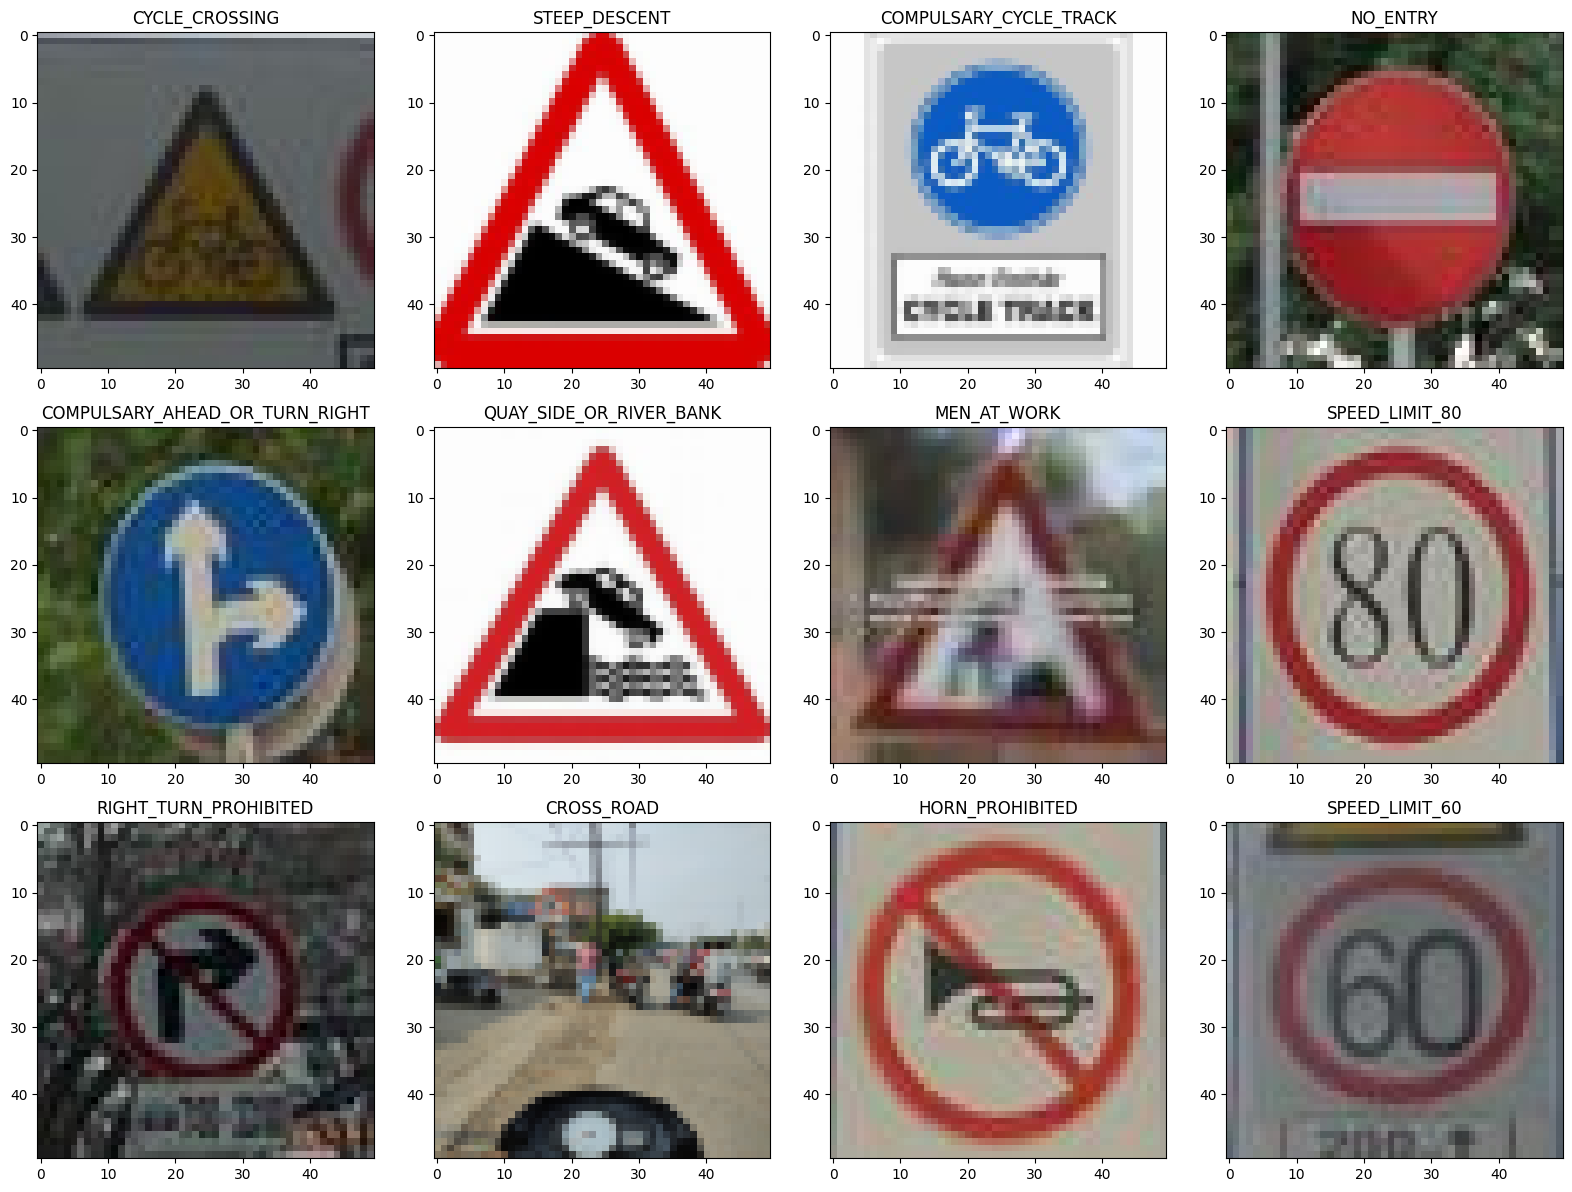

In [6]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
img,y = train_dataset.next()
for i in range(3):
    for j in range (4):
        l=rn.randint(0,batch_size-1)
        label = classes[int(list(train_dataset.class_indices.keys())[np.argmax(y[l])])]
        ax[i,j].imshow(img[l])
        ax[i,j].set_title(label)

plt.tight_layout()

In [7]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=(height,width,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Dropout(rate=0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(85, activation='softmax')
])

2024-11-17 13:57:59.829336: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-17 13:57:59.829380: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-17 13:57:59.829393: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-17 13:57:59.829662: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-17 13:57:59.829688: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 16)        1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 32)        12832     
                                                                 
 max_pooling2d (MaxPooling2  (None, 21, 21, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 21, 21, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 64)        3

In [9]:
alpha=0.01
epochs=25
optim = keras.optimizers.legacy.Adam(learning_rate=0.01)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [10]:
history = model.fit(train_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs=epochs,
                    validation_data=test_dataset,
                    validation_steps=len(test_dataset))

Epoch 1/25


2024-11-17 13:58:14.618550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 63s 2s/step - loss: 4.4610 - accuracy: 0.1575 - val_loss: 781.1456 - val_accuracy: 0.0025
Epoch 2/25
27/27 [==============================] - 39s 1s/step - loss: 3.2583 - accuracy: 0.3227 - val_loss: 89.0728 - val_accuracy: 0.0098
Epoch 3/25
27/27 [==============================] - 39s 1s/step - loss: 2.9378 - accuracy: 0.3974 - val_loss: 23.8080 - val_accuracy: 0.0737
Epoch 4/25
27/27 [==============================] - 39s 1s/step - loss: 2.2085 - accuracy: 0.4838 - val_loss: 12.9177 - val_accuracy: 0.1179
Epoch 5/25
27/27 [==============================] - 39s 1s/step - loss: 1.6779 - accuracy: 0.5701 - val_loss: 8.3278 - val_accuracy: 0.1744
Epoch 6/25
27/27 [==============================] - 39s 1s/step - loss: 1.4611 - accuracy: 0.6110 - val_loss: 4.8174 - val_accuracy: 0.2752
Epoch 7/25
27/27 [==============================] - 39s 1s/step - loss: 1.1980 - accuracy: 0.6733 - val_loss: 2.0995 - val_accuracy: 0.5111
Epoch 8/25
27/27 [========

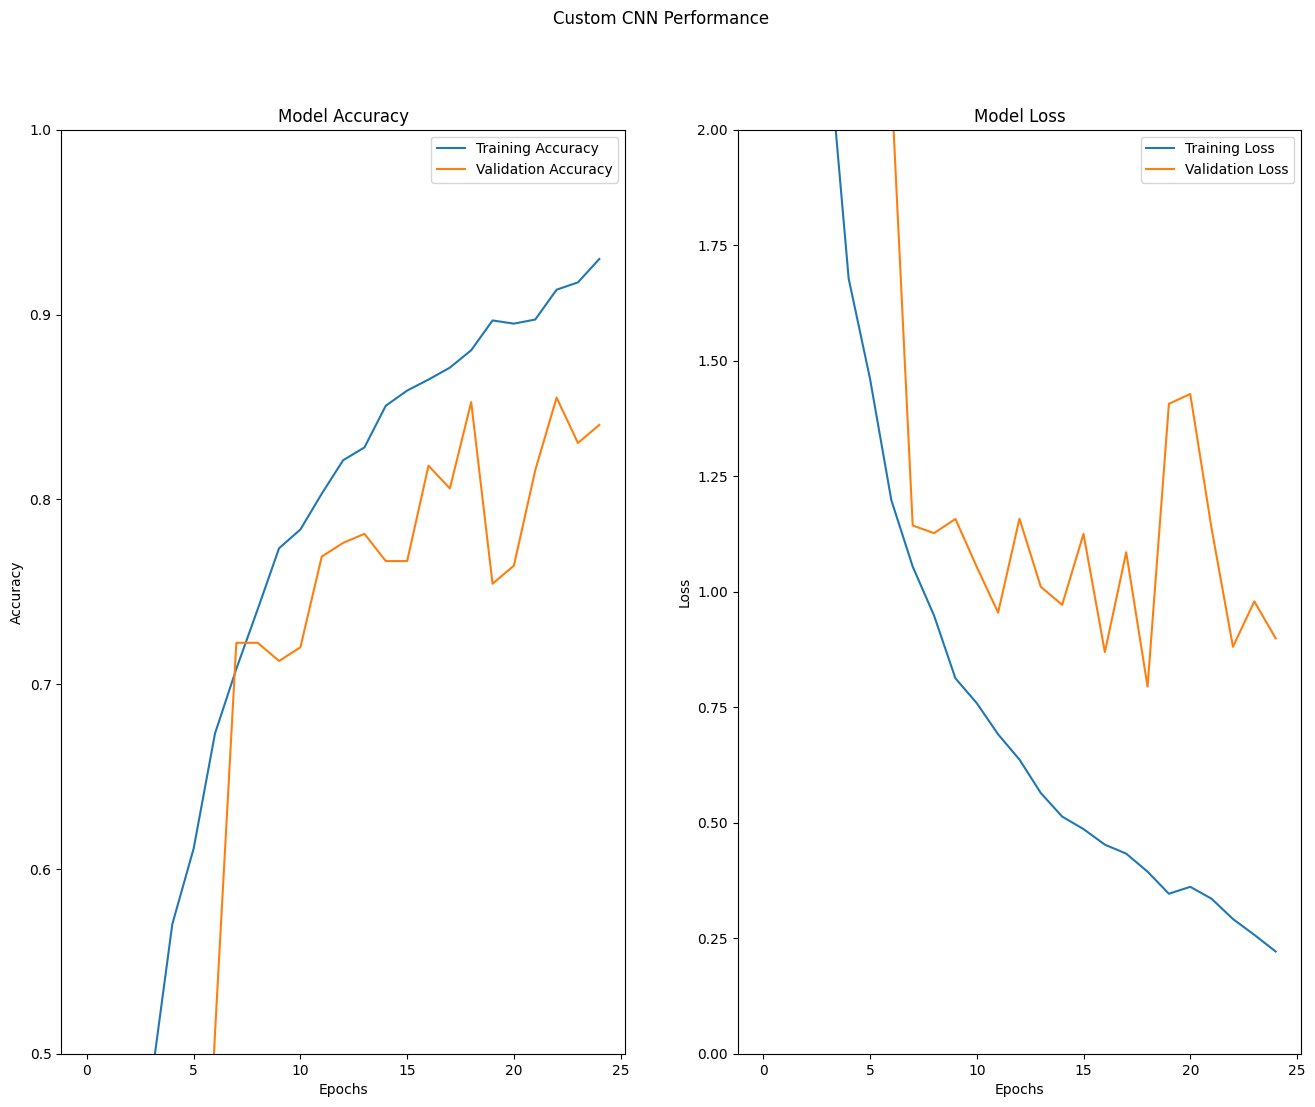

<Figure size 1000x700 with 0 Axes>

In [11]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,2)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.5,1)
fig.suptitle('Custom CNN Performance')
plt.show()

In [12]:
def map_pred(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]
# test_df = pd.read_csv('/Users/narendrafuloria/content/GTSRB/Final_Test/Images/GT-final_test.csv',delimiter=';')

destination_folder = "/Users/narendrafuloria/Indian Data Set/Dataset/test_images/"

test_labels = np.array([])
imgs = np.array([])
for filename in os.listdir(destination_folder):
    i = np.array(int(filename[0:2]))
    test_labels = np.append(test_labels , i)
    imgs = np.append(imgs,filename)
# print(imgs)


data =[]

for img in imgs:
    try:
        image = cv2.imread(destination_folder +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((height, width))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255
len(X_test)

1288

In [13]:
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
print(len(pred))
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

41/41 [==============================] - 1s 13ms/step
1288
Test Data accuracy:  59.2391304347826
